In [1]:
import gym
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16, 10)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
torch.manual_seed(0)

import base64, io

# For visualization
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display 
import glob

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
env = gym.make('MountainCar-v0')
env.seed(0)

print('observation space:', env.observation_space)
print('action space:', env.action_space)

observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
action space: Discrete(3)


In [4]:
class Policy(nn.Module):
    def __init__(self, state_size=2, action_size=3, hidden_size=32):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        #self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, action_size)
        
    def forward(self, state):
        x = F.relu(self.fc1(state))
        #x = F.relu(self.fc2(x))
        x = self.fc3(x)
        # we just consider 1 dimensional probability of action
        return F.softmax(x, dim=1)
    
    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        probs = self.forward(state).cpu()
        model = Categorical(probs)
        action = model.sample()
        return action.item(), model.log_prob(action)

In [5]:
def reinforce(policy, optimizer, n_episodes=1000, max_t=1000, gamma=1.0, print_every=100):
    scores_deque = deque(maxlen=100)
    scores = []
    for e in range(1, n_episodes):
        saved_log_probs = []
        rewards = []
        state = env.reset()
        # Collect trajectory
        for t in range(max_t):
            # Sample the action from current policy
            action, log_prob = policy.act(state)
            saved_log_probs.append(log_prob)
            state, reward, done, _ = env.step(action)
            rewards.append(reward)
            if done:
                break
        # Calculate total expected reward
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))
        
        # Recalculate the total reward applying discounted factor
        discounts = [gamma ** i for i in range(len(rewards) + 1)]
        R = sum([a * b for a,b in zip(discounts, rewards)])
        
        # Calculate the loss 
        policy_loss = []
        for log_prob in saved_log_probs:
            # Note that we are using Gradient Ascent, not Descent. So we need to calculate it with negative rewards.
            policy_loss.append(-log_prob * R)
        # After that, we concatenate whole policy loss in 0th dimension
        policy_loss = torch.cat(policy_loss).sum()
        
        # Backpropagation
        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()
        
        if e % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(e, np.mean(scores_deque)))
        if np.mean(scores_deque) >= -110.0:
            print('Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(e - 100, np.mean(scores_deque)))
            break
    return scores

In [6]:
policy = Policy().to(device)
optimizer = optim.Adam(policy.parameters(), lr=1e-2)
scores = reinforce(policy, optimizer, n_episodes=5000)

Episode 100	Average Score: -200.00
Episode 200	Average Score: -200.00
Episode 300	Average Score: -200.00
Episode 400	Average Score: -200.00
Episode 500	Average Score: -200.00
Episode 600	Average Score: -200.00
Episode 700	Average Score: -200.00
Episode 800	Average Score: -200.00
Episode 900	Average Score: -200.00
Episode 1000	Average Score: -200.00
Episode 1100	Average Score: -200.00
Episode 1200	Average Score: -200.00
Episode 1300	Average Score: -200.00
Episode 1400	Average Score: -200.00
Episode 1500	Average Score: -200.00
Episode 1600	Average Score: -200.00
Episode 1700	Average Score: -200.00
Episode 1800	Average Score: -200.00
Episode 1900	Average Score: -200.00
Episode 2000	Average Score: -200.00
Episode 2100	Average Score: -200.00
Episode 2200	Average Score: -200.00
Episode 2300	Average Score: -200.00
Episode 2400	Average Score: -200.00
Episode 2500	Average Score: -200.00
Episode 2600	Average Score: -200.00
Episode 2700	Average Score: -200.00
Episode 2800	Average Score: -200.00
E

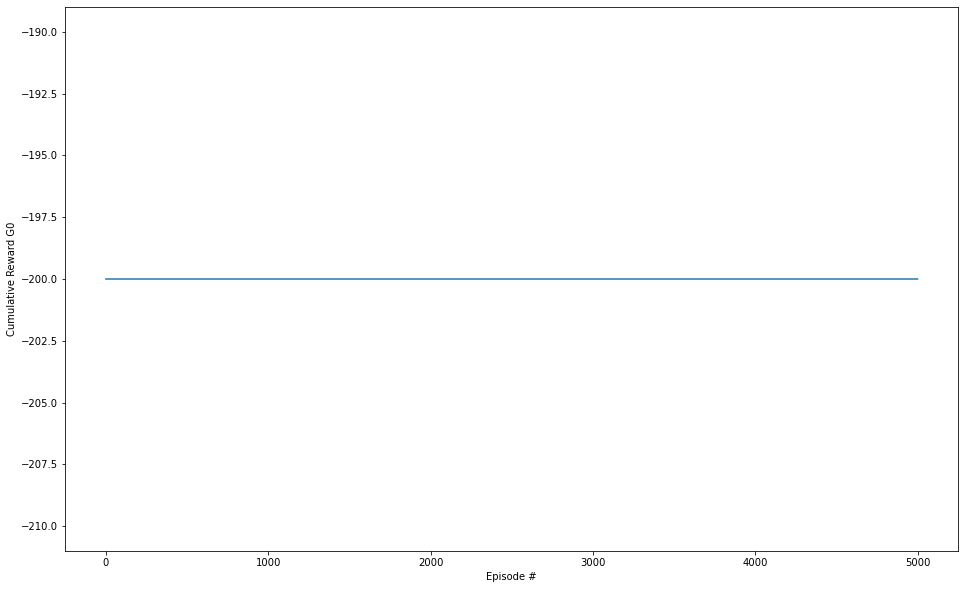

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Cumulative Reward G0')
plt.xlabel('Episode #')
plt.show()